## Day1課題_ロジスティック回帰 : Kickstarter Projects
- 実際のデータを使ってロジスティック回帰を行う

クラウドファンディング愛好家が出したKickstarterというサイトで  
行われたクラウドファンディングの過去のデータを基に成功失敗の分類を予測する。  

- ID：クラウドファンディングの個別ID
- name：クラウドファンディングの名前
- category：詳細なカテゴリー
- main_category：大まかなカテゴリー
- currency ：使用された通貨
- deadline：締め切り日時
- goal：目標調達資金額
- launched：開始した日時
- pledged：集まった資金（運用後は後から分かる変数）
- state：プロジェクトの状態(成功、失敗、キャンセルなど)＝＞教師ありデータ
- backer：集まった支援者（運用後は後から分かる変数）
- country：プロジェクトが開かれた国
- usd pledged： 集まった資金の米ドル換算（運用後は後から分かる変数）

目的変数を「state」にして、説明変数をその他全てとして検討する。

In [1]:
#import
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
# 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 


# 1.データ読み取りと内容確認

In [34]:
#データ読み取り
df_kickstarter = pd.read_csv("./ks-projects-201801.csv")

#Kickstarter Projectsに関する実際のデータ。
display(df_kickstarter.head())
df_kickstarter.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [3]:
#データ概要を取得
df_kickstarter.info()
df_kickstarter.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

## 1-1.項目を検討  
### 運用中のデータから予測するため、成功失敗判定後から分かる変数を説明変数に使用しない。  

ID                  378661 non-null int64  =>削除  
name                378657 non-null object =>削除？  
category            378661 non-null object => 数値化？   
main_category       378661 non-null object => 数値化？  
currency            378661 non-null object => ?  
deadline            378661 non-null object =>期間算定？  
goal                378661 non-null float64 => 通貨統一？、標準化？   
launched            378661 non-null object =>期間算定？    
pledged             378661 non-null float64 => 換算？又は標準化？ （後から分かる変数のため、今回は無視)  
state               378661 non-null object => 目的変数（０、１に置換)  
backers             378661 non-null int64 => （後から分かる変数のため、今回は無視）   
country             378661 non-null object  
usd pledged         374864 non-null float64  
usd_pledged_real    378661 non-null float64  
usd_goal_real       378661 non-null float64  


In [35]:
#カラム毎の欠損値の数を表示
df_kickstarter.isnull().sum()
#欠損値処理なし。name及びusd_pledgedは無視。

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


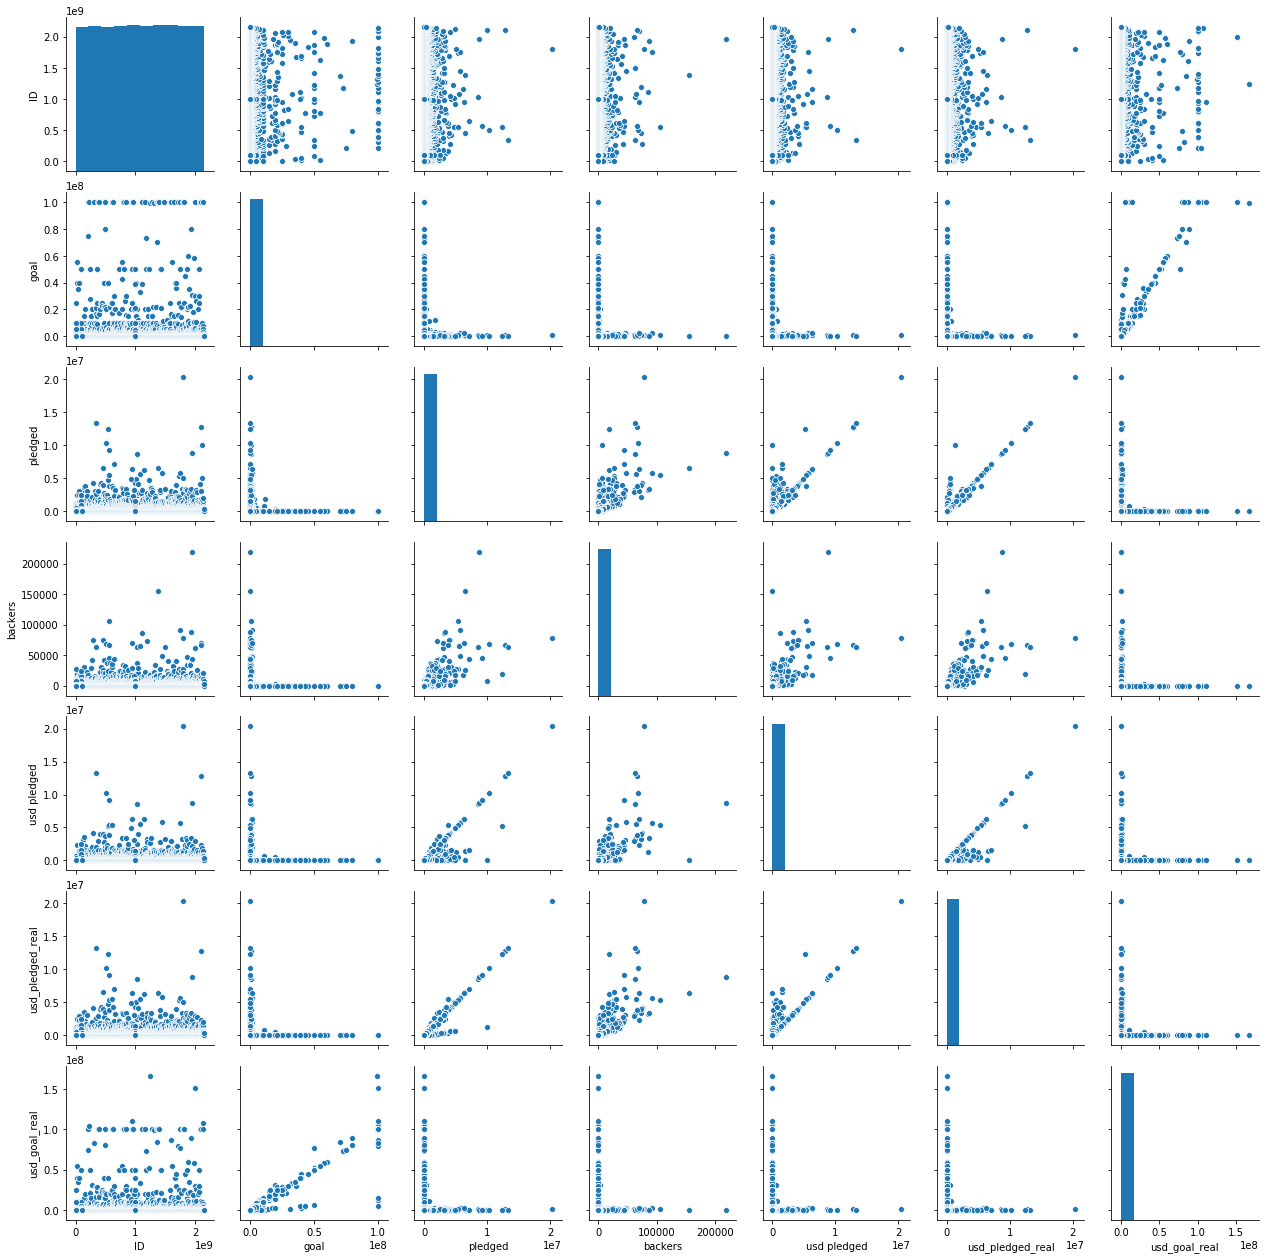

In [36]:
sns.pairplot(df_kickstarter)

In [37]:
# 相関係数を確認
df_kickstarter.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


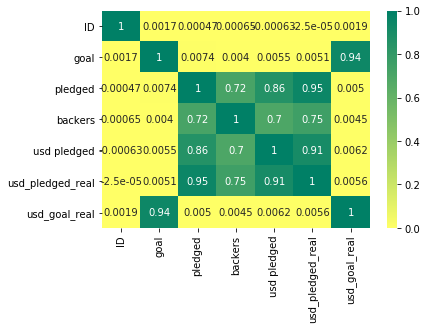

In [38]:
sns.heatmap(df_kickstarter.corr(),cmap="summer_r",annot=True)

## 2.データ修正：分類対応
## 回帰問題の説明変数として、stateを成功・失敗に分類するため、データを１、０に修正する。

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


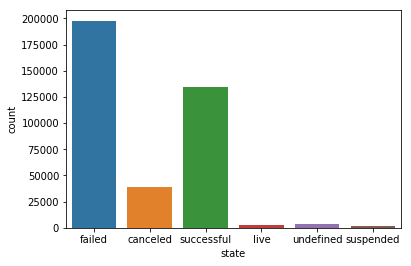

In [39]:
sns.countplot(df_kickstarter.state)
print(df_kickstarter.state.unique())
df_kickstarter.info()

### 今回は、十分にデータ件数があるため、['live' 'undefined' 'suspended']の行を削除（除外）して検討する。

In [40]:
df_kickstarter = df_kickstarter[(df_kickstarter['state']=='successful')|(df_kickstarter['state']=='failed')|(df_kickstarter['state']=='canceled')]
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370454 entries, 0 to 378660
Data columns (total 15 columns):
ID                  370454 non-null int64
name                370451 non-null object
category            370454 non-null object
main_category       370454 non-null object
currency            370454 non-null object
deadline            370454 non-null object
goal                370454 non-null float64
launched            370454 non-null object
pledged             370454 non-null float64
state               370454 non-null object
backers             370454 non-null int64
country             370454 non-null object
usd pledged         370222 non-null float64
usd_pledged_real    370454 non-null float64
usd_goal_real       370454 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 45.2+ MB


['failed' 'canceled' 'successful']


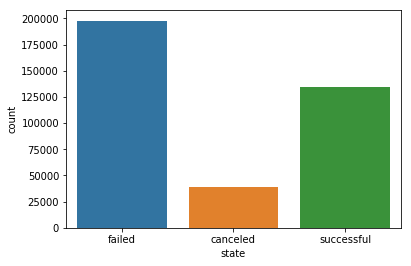

In [41]:
sns.countplot(df_kickstarter.state)
print(df_kickstarter.state.unique())

In [42]:
#successfulは１に、それ以外は、０に変換
map_state_info = {'successful':1,'failed':0,'canceled':0,'suspended':0,'undefined':0,'live':0}
df_kickstarter['state_num'] = df_kickstarter['state'].map(map_state_info)

/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[0 1]


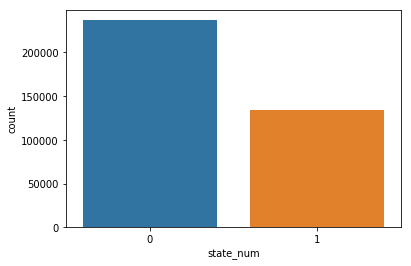

In [43]:
#データ修正結果を確認
sns.countplot(df_kickstarter.state_num)
print(df_kickstarter.state_num.unique())
#print(df_kickstarter.state.unique())

## 3.目的変数のみデータ修正して予測してみる。

In [44]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter[["goal"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

25521.088065190135 [[-55.79939299]]


In [46]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 64.223%
適合率（Precision） = 53.428%
再現率（Recall） = 8.254%
F1値（F1-score） = 14.299%


In [47]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,226860,9638
正解 = 成功,122899,11057


## 4.期間を説明変数として追加してみる。

In [48]:
#期間取得
df_kickstarter['deadline'] = pd.to_datetime(df_kickstarter['deadline'], errors='coerce')
df_kickstarter['launched'] = pd.to_datetime(df_kickstarter['launched'], errors='coerce')
df_kickstarter.head(10)

/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_num
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00,1
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00,1
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00,0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00,0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00,0


In [49]:
#期間をperiod列として追加
df_kickstarter['period'] = (df_kickstarter['deadline'] - df_kickstarter['launched']).dt.days
df_kickstarter.head(10)

/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_num,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0,55
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00,1,34
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00,1,19
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00,0,44
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00,0,34
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00,0,29


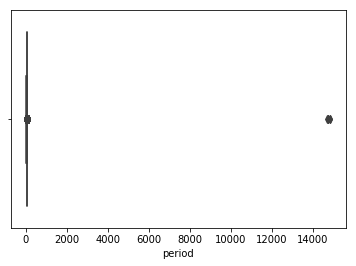

In [50]:
sns.boxplot(df_kickstarter["period"])
plt.show()

In [51]:
# 長い期間は外れ値として、行削除
df_kickstarter = df_kickstarter[(df_kickstarter['period']<2000)]
#periodのバンド化を試す
df_kickstarter['period'] = pd.cut(df_kickstarter["period"],[0, 20, 40, 60, 80, 100, 20000],labels=range(6),right=False)
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370448 entries, 0 to 378660
Data columns (total 17 columns):
ID                  370448 non-null int64
name                370445 non-null object
category            370448 non-null object
main_category       370448 non-null object
currency            370448 non-null object
deadline            370448 non-null datetime64[ns]
goal                370448 non-null float64
launched            370448 non-null datetime64[ns]
pledged             370448 non-null float64
state               370448 non-null object
backers             370448 non-null int64
country             370448 non-null object
usd pledged         370216 non-null float64
usd_pledged_real    370448 non-null float64
usd_goal_real       370448 non-null float64
state_num           370448 non-null int64
period              370448 non-null category
dtypes: category(1), datetime64[ns](2), float64(5), int64(3), object(6)
memory usage: 48.4+ MB


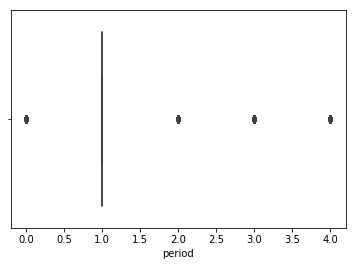

In [52]:
sns.boxplot(df_kickstarter["period"])
plt.show()

[2, 1, 0, 3, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]


ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         232
usd_pledged_real      0
usd_goal_real         0
state_num             0
period                0
dtype: int64

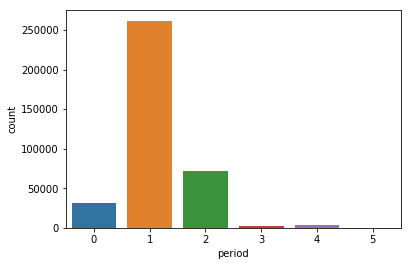

In [53]:
print(df_kickstarter.period.unique())
sns.countplot(df_kickstarter.period)
df_kickstarter.isnull().sum()

In [54]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter[["goal","period"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
print(clf.fit(X, y))

# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
22684.092669455284 [[ -802.23074616 23629.5863229 ]]


In [55]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

正答率（Accuracy） = 63.883%
適合率（Precision） = 52.582%
再現率（Recall） = 1.216%
F1値（F1-score） = 2.377%


,予測 = 失敗,予測 = 成功
正解 = 失敗,235023,1469
正解 = 成功,132327,1629


## 期間をバンド化にすることで性能低下回避？。期間の取り扱いは要検討。

# 5.'country','currency','main_category'をダミー変数として説明変数に追加する。

In [56]:
df_kickstarter['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [57]:
df_dummy = pd.get_dummies(df_kickstarter['main_category'])
df_kickstarter = pd.concat([df_kickstarter,df_dummy],axis=1)
df_dummy = pd.get_dummies(df_kickstarter['currency'])
df_kickstarter = pd.concat([df_kickstarter,df_dummy],axis=1)
df_dummy = pd.get_dummies(df_kickstarter['country'])
df_kickstarter = pd.concat([df_kickstarter,df_dummy],axis=1)
df_kickstarter.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,...,0,0,0,0,0,0,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,...,0,0,0,0,0,0,0,0,0,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,...,0,0,0,0,0,0,0,0,0,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,...,0,0,0,0,0,0,0,0,0,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,...,0,0,0,0,0,0,0,0,0,1
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,...,0,0,0,0,0,0,0,0,0,1
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,...,0,0,0,0,0,0,0,0,0,1
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,...,0,0,0,0,0,0,0,0,0,1
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,...,0,0,0,0,0,0,0,0,0,1
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,...,0,0,0,0,0,0,0,0,0,1


In [58]:
#不要な列を削除
drop_colums = ['ID','name','pledged','backers','usd pledged','usd_pledged_real','usd_goal_real']
df_kickstarter = df_kickstarter.drop(drop_colums, axis = 1)

#別データに変更したもの
drop_colums = ['state','deadline','country','currency','category','main_category','launched']
df_kickstarter = df_kickstarter.drop(drop_colums, axis = 1)

In [59]:
#カラム毎の欠損値の数を表示
df_kickstarter.isnull().sum()

goal            0
state_num       0
period          0
Art             0
Comics          0
Crafts          0
Dance           0
Design          0
Fashion         0
Film & Video    0
Food            0
Games           0
Journalism      0
Music           0
Photography     0
Publishing      0
Technology      0
Theater         0
AUD             0
CAD             0
CHF             0
DKK             0
EUR             0
GBP             0
HKD             0
JPY             0
MXN             0
NOK             0
NZD             0
SEK             0
SGD             0
USD             0
AT              0
AU              0
BE              0
CA              0
CH              0
DE              0
DK              0
ES              0
FR              0
GB              0
HK              0
IE              0
IT              0
JP              0
LU              0
MX              0
N,0"            0
NL              0
NO              0
NZ              0
SE              0
SG              0
US              0
dtype: int

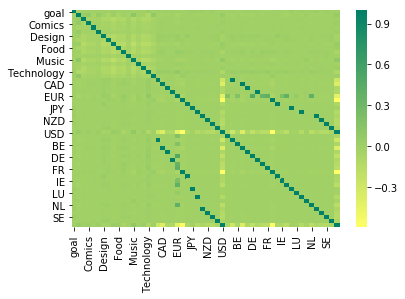

In [60]:
sns.heatmap(df_kickstarter.corr(),cmap="summer_r")

In [61]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter.drop('state_num', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
print(clf.fit(X, y))

# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
22780.016599039038 [[-4.75262328e+02  2.37669178e+04  1.84713441e+03  1.12110385e+03
   2.80987532e+02  4.97640820e+02  1.84413929e+03  7.46580498e+02
   4.15470076e+03  8.02297541e+02  2.16508869e+03  1.43246231e+02
   4.60469070e+03  4.84857852e+02  1.92708116e+03  7.90830377e+02
   1.36963688e+03  2.73853247e+02  6.45623280e+02  2.26295600e+01
   5.09622569e+01  5.45439887e+02  1.91669541e+03  3.93114796e+01
  -1.20477221e+00  6.21721626e+01  2.50021051e+01  1.02314161e+02
   7.59555278e+01  2.97087641e+01  1.89915535e+04  1.44398648e+01
   2.73730333e+02  2.44239866e+01  6.45336564e+02 

In [62]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

正答率（Accuracy） = 63.953%
適合率（Precision） = 52.913%
再現率（Recall） = 2.855%
F1値（F1-score） = 5.417%


,予測 = 失敗,予測 = 成功
正解 = 失敗,233089,3403
正解 = 成功,130132,3824


## 6.期間を除外して計算（ダミー変数とgoalを説明変数で予測）

In [63]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter.drop(['state_num','period'], axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
print(clf.fit(X, y))

# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
22946.791750561042 [[-1.19385951e+03  1.86658370e+03  1.13676511e+03  2.87085758e+02
   5.00792257e+02  1.85604403e+03  7.50041765e+02  4.17590538e+03
   7.98160348e+02  2.17393790e+03  1.44246006e+02  4.65673895e+03
   4.93070717e+02  1.94275527e+03  7.79828158e+02  1.38483641e+03
   2.77163101e+02  6.55862651e+02  2.23163902e+01  5.00566155e+01
   5.46565467e+02  1.95811932e+03  3.88298262e+01 -1.37900901e+00
   6.12807537e+01  2.47773821e+01  1.01763123e+02  7.57731125e+01
   2.94923064e+01  1.91061707e+04  1.44138090e+01  2.77044498e+02
   2.42773603e+01  6.55560709e+02  2.23163902e+01 

In [64]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

正答率（Accuracy） = 63.913%
適合率（Precision） = 54.729%
再現率（Recall） = 1.171%
F1値（F1-score） = 2.292%


,予測 = 失敗,予測 = 成功
正解 = 失敗,235195,1297
正解 = 成功,132388,1568
